# GraphCast: 基于图神经网络的全球中期天气预报

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/zh_cn/medium-range/mindspore_graphcast.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/zh_cn/medium-range/mindspore_graphcast.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindearth/docs/source_zh_cn/medium-range/graphcast.ipynb)

## 概述

GraphCast是由DeepMind和Google的研究人员开发的一个基于数据驱动的全球天气预报模型。它提供了关键全球天气指标的中期预报，分辨率为0.25°。相当于赤道附近约25公里x25公里的空间分辨率和大小为721 x 1440像素的全球网格。与以前的基于MachineLearning的天气预报模型相比，该模型将252个目标的准确率提高到99.2%。

本教程介绍了GraphCast的研究背景和技术路径，并展示了如何通过MindSpore Earth训练和快速推理模型。 更多信息参见[文章](https://arxiv.org/abs/2212.12794)。本教程中使用分辨率为1.4°的部分数据集，结果如下所示。

## GraphCast

为了实现高分辨率预测，GraphCast在“encode-process-decode”模型中使用GNN作为骨干网。基于GNN的网络体系结构专为复杂的输入物理动力学而设计，使用消息传递，允许在任何范围内进行任意空间交互模式。该模型使用多网格表示，允许在几个步骤内进行远程交互。

下图展示了GraphCast的网络架构

![GraphCast model](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindearth/docs/source_zh_cn/medium-range/images/GraphCast.jpg)

1. Input weather state: 高分辨率经纬度压力级网格表示了图（a）中的地表变量（黄色层）和大气变量（蓝色层）

2. Predict the next state: GraphCast模型通过当前时间状态和上一个时间状态预测下一步天气状态。形式如下：

$$
\hat X^{t-1} = GraphCast(X^t, X^{t-1})
$$

3. Roll out a forecast: GraphCast迭代生成T步预测。格式如下：

$$
\hat X^{t+1:t+T} = (GraphCast(X^t, X^{t-1}), GraphCast(X^{t+1}, X^{t}), ..., GraphCast(\hat X^{t+T-1}, \hat X^{t+T-2}))
$$

4. Encoder-Processor-Decoder: GraphCast模型包括编码器层、处理器层和解码器层。

    在编码器层中，所有输入特征都使用多层感知器（MLP）嵌入到隐层空间中。该模型使用消息传递步骤将原始经纬度网格传输到多网格。

    在处理器层中，一个16层深度GNN，用于学习包含所有多网格边缘的多网格上的长程边缘。对于每个GNN层，相邻节点用于更新网格边缘。然后，它通过聚合连接该节点的所有边的信息来更新网格节点。然后，向更新的边和节点添加残留连接。

    在解码器层中，它将多网格信息映射回原始经纬度网格，该网格通过聚合信息将网格更新为网格边缘。然后，向更新的边和节点添加残留连接。

5. Simultaneous multi-mesh message-passing: GraphCast的关键是多网格表示。多网格是一组二十面体网格$M^R$.

## 技术路径

MindSpore Earth求解该问题的具体流程如下:

1. 创建数据集
2. 模型构建
3. 损失函数
4. 模型训练
5. 模型评估与可视化

训练和测试所用的数据集可以在: [graphcast/dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/WeatherBench_1.4_69/) 下载。

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

from mindspore import set_seed
from mindspore import context, Model
from mindspore.train.loss_scale_manager import DynamicLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net

[WARNING] ME(3378466:281473107075104,MainProcess):2024-11-26-20:00:29.849.000 [mindspore/run_check/_check_version.py:348] Using custom Ascend AI software package (Ascend Data Center Solution) path, package version checking is skipped. Please make sure Ascend AI software package (Ascend Data Center Solution) version is supported. For details, refer to the installation guidelines https://www.mindspore.cn/install
[WARNING] ME(3378466:281473107075104,MainProcess):2024-11-26-20:00:29.851.000 [mindspore/run_check/_check_version.py:462] Can not find the tbe operator implementation(need by mindspore-ascend). Please check whether the Environment Variable PYTHONPATH is set. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(3378466:281473107075104,MainProcess):2024-11-26-20:00:29.851.000 [mindspore/run_check/_check_version.py:469] Can not find driver so(need by mindspore-ascend). Please check whether the Environment Variable LD_LIBRARY_PATH is set. F

下述`src`可以在[graphcast/src](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/medium-range/graphcast/src)下载。

In [4]:
from mindearth.utils import load_yaml_config, create_logger, plt_global_field_data, make_dir
from mindearth.module import Trainer
from mindearth.data import Dataset, Era5Data
from mindearth.cell import GraphCastNet

from src import get_coe, GridMeshInfo
from src import EvaluateCallBack, LossNet, CustomWithLossCell, InferenceModule

In [5]:
set_seed(0)
np.random.seed(0)
random.seed(0)

模型涉及的参数、优化器、数据配置见[config](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/graphcast/configs/GraphCast_0.25.yaml)。

In [6]:
# set context for training: using graph mode for high performance training with Ascend acceleration
config = load_yaml_config("./configs/GraphCast_1.4.yaml")
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)

[WARNING] ME(3378466:281473107075104,MainProcess):2024-11-26-20:00:42.330.00 [mindspore/run_check/_check_version.py:348] Using custom Ascend AI software package (Ascend Data Center Solution) path, package version checking is skipped. Please make sure Ascend AI software package (Ascend Data Center Solution) version is supported. For details, refer to the installation guidelines https://www.mindspore.cn/install
[WARNING] ME(3378466:281473107075104,MainProcess):2024-11-26-20:00:42.340.00 [mindspore/run_check/_check_version.py:462] Can not find the tbe operator implementation(need by mindspore-ascend). Please check whether the Environment Variable PYTHONPATH is set. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(3378466:281473107075104,MainProcess):2024-11-26-20:00:42.350.00 [mindspore/run_check/_check_version.py:469] Can not find driver so(need by mindspore-ascend). Please check whether the Environment Variable LD_LIBRARY_PATH is set. For 

## 创建数据集

在[dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/WeatherBench_1.4_69/)路径下，下载正则化参数、训练数据集验证数据集到 `./dataset`目录。

修改[GraphCast.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/graphcast/configs/GraphCast_0.25.yaml)配置文件中的`root_dir`参数，该参数设置了数据集的路径。

`./dataset`中的目录结构如下所示：

``` markdown
.
├── statistic
│   ├── mean.npy
│   ├── mean_s.npy
│   ├── std.npy
│   └── std_s.npy
├── train
│   └── 2015
├── train_static
│   └── 2015
├── train_surface
│   └── 2015
├── train_surface_static
│   └── 2015
├── valid
│   └── 2016
├── valid_static
│   └── 2016
├── valid_surface
│   └── 2016
├── valid_surface_static
│   └── 2016
```


## 模型构建

模型初始化包括：

1. 加载mesh和grid的信息。

2. 加载per-variable-level在各时间差下的逆方差。

In [7]:
config['data']['data_sink'] = True # 是否使用data sink特性
config['data']['h_size'], config['data']['w_size'] = 128, 256 # 纬度和经度方向上的网格点数

config['optimizer']['epochs'] = 100 # 训练轮数
config['optimizer']['initial_lr'] = 0.00025 # 初始学习率

config['summary']["eval_interval"] = 10 # 评估间隔
config['summary']['plt_key_info'] = False # 是否绘制关键信息图
config['summary']["summary_dir"] = './summary' # 设置模型checkpoint的存储路径
make_dir(os.path.join(config['summary']["summary_dir"], "image"))
logger = create_logger(os.path.join(os.path.abspath(config['summary']["summary_dir"]), "results.log"))

In [8]:
data_params = config.get("data")
model_params = config.get("model")
grid_mesh_info = GridMeshInfo(data_params)
model = GraphCastNet(vg_in_channels=data_params.get('feature_dims') * data_params.get('t_in'),
                     vg_out_channels=data_params.get('feature_dims'),
                     vm_in_channels=model_params.get('vm_in_channels'),
                     em_in_channels=model_params.get('em_in_channels'),
                     eg2m_in_channels=model_params.get('eg2m_in_channels'),
                     em2g_in_channels=model_params.get('em2g_in_channels'),
                     latent_dims=model_params.get('latent_dims'),
                     processing_steps=model_params.get('processing_steps'),
                     g2m_src_idx=grid_mesh_info.g2m_src_idx,
                     g2m_dst_idx=grid_mesh_info.g2m_dst_idx,
                     m2m_src_idx=grid_mesh_info.m2m_src_idx,
                     m2m_dst_idx=grid_mesh_info.m2m_dst_idx,
                     m2g_src_idx=grid_mesh_info.m2g_src_idx,
                     m2g_dst_idx=grid_mesh_info.m2g_dst_idx,
                     mesh_node_feats=grid_mesh_info.mesh_node_feats,
                     mesh_edge_feats=grid_mesh_info.mesh_edge_feats,
                     g2m_edge_feats=grid_mesh_info.g2m_edge_feats,
                     m2g_edge_feats=grid_mesh_info.m2g_edge_feats,
                     per_variable_level_mean=grid_mesh_info.sj_mean,
                     per_variable_level_std=grid_mesh_info.sj_std,
                     recompute=model_params.get('recompute', False))

## 损失函数

GraphCast在模型训练中使用自定义均方差。计算公式为：

![Loss function](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindearth/docs/source_zh_cn/medium-range/images/loss.png)

In [9]:
sj_std, wj, ai = get_coe(config)
loss_fn = LossNet(ai, wj, sj_std, config.get('data').get('feature_dims'))
loss_cell = CustomWithLossCell(backbone=model, loss_fn=loss_fn, data_params=config.get('data'))

## 模型训练

在本教程中，我们继承了`Trainer`并重写了`get_solver`成员函数来构建自定义损失函数，并重写了`get_callback`成员函数来在训练过程中对测试数据集执行推理。

MindSpore Earth提供训练和推理接口，使用1.8.1及之后的MindSpore训练网络。

In [10]:
class GraphCastTrainer(Trainer):
    def __init__(self, config, model, loss_fn, logger):
        super().__init__(config, model, loss_fn, logger)
        self.train_dataset, self.valid_dataset = self.get_dataset()
        self.pred_cb = self.get_callback()
        self.solver = self.get_solver()

    def get_solver(self):
        loss_scale = DynamicLossScaleManager()
        solver = Model(network=self.loss_fn,
                       optimizer=self.optimizer,
                       loss_scale_manager=loss_scale,
                       amp_level=self.train_params.get('amp_level'),
                       )
        return solver

    def get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb


In [ ]:
trainer = GraphCastTrainer(config, model, loss_cell, logger)
trainer.train()

2024-11-26 17:26:43,628 - pretrain.py[line:229] - INFO: steps_per_epoch: 403
2024-11-26 17:26:43,628 - pretrain.py[line:229] - INFO: steps_per_epoch: 403
[WARNING] ME(2487481:281473501626400,MainProcess):2024-11-26-17:26:44.474.000 [mindspore/train/model.py:1328] For EvaluateCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] GE_ADPT(2487481,ffffa8140020,python):2024-11-26-17:27:08.667.214 [mindspore/ccsrc/transform/acl_ir/acl_convert.cc:310] GetValueSequenceDataTypeAndShape] value sequence is empty, failed to get data type
[WARNING] GE_ADPT(2487481,ffffa8140020,python):2024-11-26-17:27:09.601.444 [mindspore/ccsrc/transform/acl_ir/acl_convert.cc:310] GetValueSequenceDataTypeAndShape] value sequence is empty, failed to get data type


epoch: 1 step: 403, loss is 0.0041844943
Train epoch time: 116168.987 ms, per step time: 288.261 ms
epoch: 2 step: 403, loss is 0.0036578872
Train epoch time: 48317.040 ms, per step time: 119.893 ms
epoch: 3 step: 403, loss is 0.003080408
Train epoch time: 47330.261 ms, per step time: 117.445 ms
epoch: 4 step: 403, loss is 0.0031271814
Train epoch time: 47509.634 ms, per step time: 117.890 ms
epoch: 5 step: 403, loss is 0.0025536916
Train epoch time: 48050.349 ms, per step time: 119.232 ms
epoch: 6 step: 403, loss is 0.0025403432
Train epoch time: 49468.810 ms, per step time: 122.751 ms
epoch: 7 step: 403, loss is 0.0024950323
Train epoch time: 47995.286 ms, per step time: 119.095 ms
epoch: 8 step: 403, loss is 0.0022424967
Train epoch time: 51570.132 ms, per step time: 127.966 ms
epoch: 9 step: 403, loss is 0.0020817127
Train epoch time: 48543.422 ms, per step time: 120.455 ms
epoch: 10 step: 403, loss is 0.0021805048
Train epoch time: 49544.255 ms, per step time: 122.939 ms


2024-11-26 17:35:59,028 - callback.py[line:135] - INFO: ================================Start Evaluation================================
2024-11-26 17:35:59,028 - callback.py[line:135] - INFO: ================================Start Evaluation================================
[WARNING] GE_ADPT(2487481,ffffa8140020,python):2024-11-26-17:36:13.956.888 [mindspore/ccsrc/transform/acl_ir/acl_convert.cc:310] GetValueSequenceDataTypeAndShape] value sequence is empty, failed to get data type


2024-11-26 17:36:32,727 - callback.py[line:153] - INFO: test dataset size: 8
2024-11-26 17:36:32,727 - callback.py[line:153] - INFO: test dataset size: 8
2024-11-26 17:36:32,731 - forecast.py[line:327] - INFO: t = 6 hour: 
2024-11-26 17:36:32,731 - forecast.py[line:327] - INFO: t = 6 hour: 
2024-11-26 17:36:32,733 - forecast.py[line:329] - INFO:  RMSE of Z500: 123.08521832247342, T2m: 1.2977536642314789, T850: 1.0978262261101743, U10: 1.2820525242003449
2024-11-26 17:36:32,733 - forecast.py[line:329] - INFO:  RMSE of Z500: 123.08521832247342, T2m: 1.2977536642314789, T850: 1.0978262261101743, U10: 1.2820525242003449
2024-11-26 17:36:32,735 - forecast.py[line:333] - INFO:  ACC  of Z500: 0.9961627339556338, T2m: 0.991350567260655, T850: 0.9832665066698412, U10: 0.976284347614753
2024-11-26 17:36:32,735 - forecast.py[line:333] - INFO:  ACC  of Z500: 0.9961627339556338, T2m: 0.991350567260655, T850: 0.9832665066698412, U10: 0.976284347614753
2024-11-26 17:36:32,737 - forecast.py[line:327] 

epoch: 11 step: 403, loss is 0.0020441003
Train epoch time: 46392.457 ms, per step time: 115.118 ms
epoch: 12 step: 403, loss is 0.0019680762
Train epoch time: 59971.442 ms, per step time: 148.813 ms
epoch: 13 step: 403, loss is 0.0020139168
Train epoch time: 59408.240 ms, per step time: 147.415 ms
epoch: 14 step: 403, loss is 0.001810069
Train epoch time: 59556.415 ms, per step time: 147.783 ms
epoch: 15 step: 403, loss is 0.0018878222
Train epoch time: 57004.215 ms, per step time: 141.450 ms


2023-08-18 08:39:45,287 - forecast.py[line:204] - INFO: ================================Start Evaluation================================
2023-08-18 08:40:41,617 - forecast.py[line:222] - INFO: test dataset size: 8
2023-08-18 08:40:41,621 - forecast.py[line:173] - INFO: t = 6 hour: 
2023-08-18 08:40:41,622 - forecast.py[line:183] - INFO:  RMSE of Z500: 99.63094225503905, T2m: 1.7807282244821678, T850: 1.1389199313716583, U10: 1.3300655484052706
2023-08-18 08:40:41,623 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9995030164718628, T2m: 0.9949086904525757, T850: 0.9965617656707764, U10: 0.9709641933441162
2023-08-18 08:40:41,624 - forecast.py[line:173] - INFO: t = 72 hour: 
2023-08-18 08:40:41,625 - forecast.py[line:183] - INFO:  RMSE of Z500: 846.2669541832905, T2m: 5.095069601461138, T850: 4.291456435667611, U10: 5.033789250954006
2023-08-18 08:40:41,627 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9656049013137817, T2m: 0.9600029587745667, T850: 0.9581822752952576, U10: 0.59237

......

epoch: 91 step: 403, loss is 0.00090005953
Train epoch time: 48299.581 ms, per step time: 119.850 ms
epoch: 92 step: 403, loss is 0.0009103894
Train epoch time: 48302.468 ms, per step time: 119.857 ms
epoch: 93 step: 403, loss is 0.00090527127
Train epoch time: 48296.220 ms, per step time: 119.842 ms
epoch: 94 step: 403, loss is 0.0009113429
Train epoch time: 48314.221 ms, per step time: 119.886 ms
epoch: 95 step: 403, loss is 0.0008906296
Train epoch time: 48332.578 ms, per step time: 119.932 ms
epoch: 96 step: 403, loss is 0.0009023069
Train epoch time: 48344.677 ms, per step time: 119.962 ms
epoch: 97 step: 403, loss is 0.00088527385
Train epoch time: 48319.437 ms, per step time: 119.899 ms
epoch: 98 step: 403, loss is 0.00087669905
Train epoch time: 48319.398 ms, per step time: 119.899 ms
epoch: 99 step: 403, loss is 0.00088527397
Train epoch time: 48305.233 ms, per step time: 119.864 ms
epoch: 100 step: 403, loss is 0.00093020557
Train epoch time: 49486.354 ms, per step time: 122.

2023-08-18 09:57:55,343 - forecast.py[line:204] - INFO: ================================Start Evaluation================================
2023-08-18 09:58:29,557 - forecast.py[line:222] - INFO: test dataset size: 8
2023-08-18 09:58:29,562 - forecast.py[line:173] - INFO: t = 6 hour: 
2023-08-18 09:58:29,563 - forecast.py[line:183] - INFO:  RMSE of Z500: 71.52867536392974, T2m: 1.1144296184615285, T850: 0.950450431058116, U10: 1.2159413055648252
2023-08-18 09:58:29,564 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9997411966323853, T2m: 0.9980063438415527, T850: 0.9975705146789551, U10: 0.9757701754570007
2023-08-18 09:58:29,566 - forecast.py[line:173] - INFO: t = 72 hour: 
2023-08-18 09:58:29,567 - forecast.py[line:183] - INFO:  RMSE of Z500: 564.955831718179, T2m: 3.2896556874900664, T850: 2.986913832820727, U10: 3.7879051445350314
2023-08-18 09:58:29,568 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9842368364334106, T2m: 0.9827487468719482, T850: 0.9765684008598328, U10: 0.77273

## 模型评估和可视化

完成训练后，我们使用第100个ckpt进行推理。下述展示了预测值、地表和它们之间的误差可视化。

In [12]:
params = load_checkpoint('./summary/ckpt/step_1/GraphCast-100_403.ckpt')
load_param_into_net(model, params)
inference_module = InferenceModule(model, config, logger)

In [ ]:
data_params = config.get("data")
test_dataset_generator = Era5Data(data_params=data_params, run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=data_params.get('num_workers'), shuffle=False)
test_dataset = test_dataset.create_dataset(data_params.get('batch_size'))
data = next(test_dataset.create_dict_iterator())
inputs = data['inputs']
labels = data['labels']


inputs.shape (1, 32768, 138)
labels.shape (1, 20, 32768, 69)


In [ ]:
labels = labels[..., 0, :, :]
labels = labels.transpose(0, 2, 1)
labels = labels.reshape(labels.shape[0], labels.shape[1], data_params.get("h_size"), data_params.get("w_size")).asnumpy()

pred = inference_module.forecast(inputs)
pred = pred[0].transpose(1, 0)
pred = pred.reshape(pred.shape[0], data_params.get("h_size"), data_params.get("w_size")).asnumpy()
pred = np.expand_dims(pred, axis=0)

inputs.shape (1, 69, 128, 256)
labels.shape (1, 69, 128, 256)


In [ ]:
def plt_key_info_comparison(pred, label, root_dir):
    """ Visualize the comparison of forecast results """
    std = np.load(os.path.join(root_dir, 'statistic/std.npy'))
    mean = np.load(os.path.join(root_dir, 'statistic/mean.npy'))
    std_s = np.load(os.path.join(root_dir, 'statistic/std_s.npy'))
    mean_s = np.load(os.path.join(root_dir, 'statistic/mean_s.npy'))
    plt.figure(num='e_imshow', figsize=(100, 50))

    plt.subplot(4, 3, 1)
    plt_global_field_data(label, 'Z500', std, mean, 'Ground Truth')  # Z500
    plt.subplot(4, 3, 2)
    plt_global_field_data(pred, 'Z500', std, mean, 'Pred')  # Z500
    plt.subplot(4, 3, 3)
    plt_global_field_data(label - pred, 'Z500', std, mean, 'Error', is_error=True)  # Z500

    plt.subplot(4, 3, 4)
    plt_global_field_data(label, 'T850', std, mean, 'Ground Truth')  # T850
    plt.subplot(4, 3, 5)
    plt_global_field_data(pred, 'T850', std, mean, 'Pred')  # T850
    plt.subplot(4, 3, 6)
    plt_global_field_data(label - pred, 'T850', std, mean, 'Error', is_error=True)  # T850

    plt.subplot(4, 3, 7)
    plt_global_field_data(label, 'U10', std_s, mean_s, 'Ground Truth', is_surface=True)  # U10
    plt.subplot(4, 3, 8)
    plt_global_field_data(pred, 'U10', std_s, mean_s, 'Pred', is_surface=True)  # U10
    plt.subplot(4, 3, 9)
    plt_global_field_data(label - pred, 'U10', std_s, mean_s, 'Error', is_surface=True, is_error=True)  # U10
    plt.subplot(4, 3, 10)
    plt_global_field_data(label, 'T2M', std_s, mean_s, 'Ground Truth', is_surface=True)  # T2M
    plt.subplot(4, 3, 11)
    plt_global_field_data(pred, 'T2M', std_s, mean_s, 'Pred', is_surface=True)  # T2M
    plt.subplot(4, 3, 12)
    plt_global_field_data(label - pred, 'T2M', std_s, mean_s, 'Error', is_surface=True, is_error=True)  # T2M
    plt.savefig(f'key_info_comparison.png', bbox_inches='tight')
    plt.show()

-1
feature_data [[-0.9334605  -0.9334605  -0.9334605  ... -0.93443555 -0.93443555
  -0.93443555]
 [-0.94419104 -0.9432148  -0.9422397  ... -0.94711745 -0.94614124
  -0.9451661 ]
 [-0.9597983  -0.9578481  -0.95589674 ... -0.9656511  -0.96370095
  -0.9617496 ]
 ...
 [-0.8924894  -0.8885867  -0.88566023 ... -0.9012686  -0.8983422
  -0.8954158 ]
 [-0.8915131  -0.89053804 -0.8885867  ... -0.89639086 -0.8954158
  -0.89346445]
 [-0.91394943 -0.9129743  -0.9129743  ... -0.91492563 -0.91394943
  -0.91394943]]
feature_data [[50999.242 50999.242 50999.242 ... 50995.97  50995.97  50995.97 ]
 [50963.22  50966.496 50969.77  ... 50953.395 50956.67  50959.945]
 [50910.824 50917.37  50923.92  ... 50891.176 50897.723 50904.273]
 ...
 [51136.785 51149.887 51159.71  ... 51107.312 51117.137 51126.96 ]
 [51140.062 51143.336 51149.887 ... 51123.688 51126.96  51133.51 ]
 [51064.742 51068.016 51068.016 ... 51061.465 51064.742 51064.742]]
feature_data [[-0.95006895 -0.9500091  -0.94982404 ... -0.95125014 -0.951

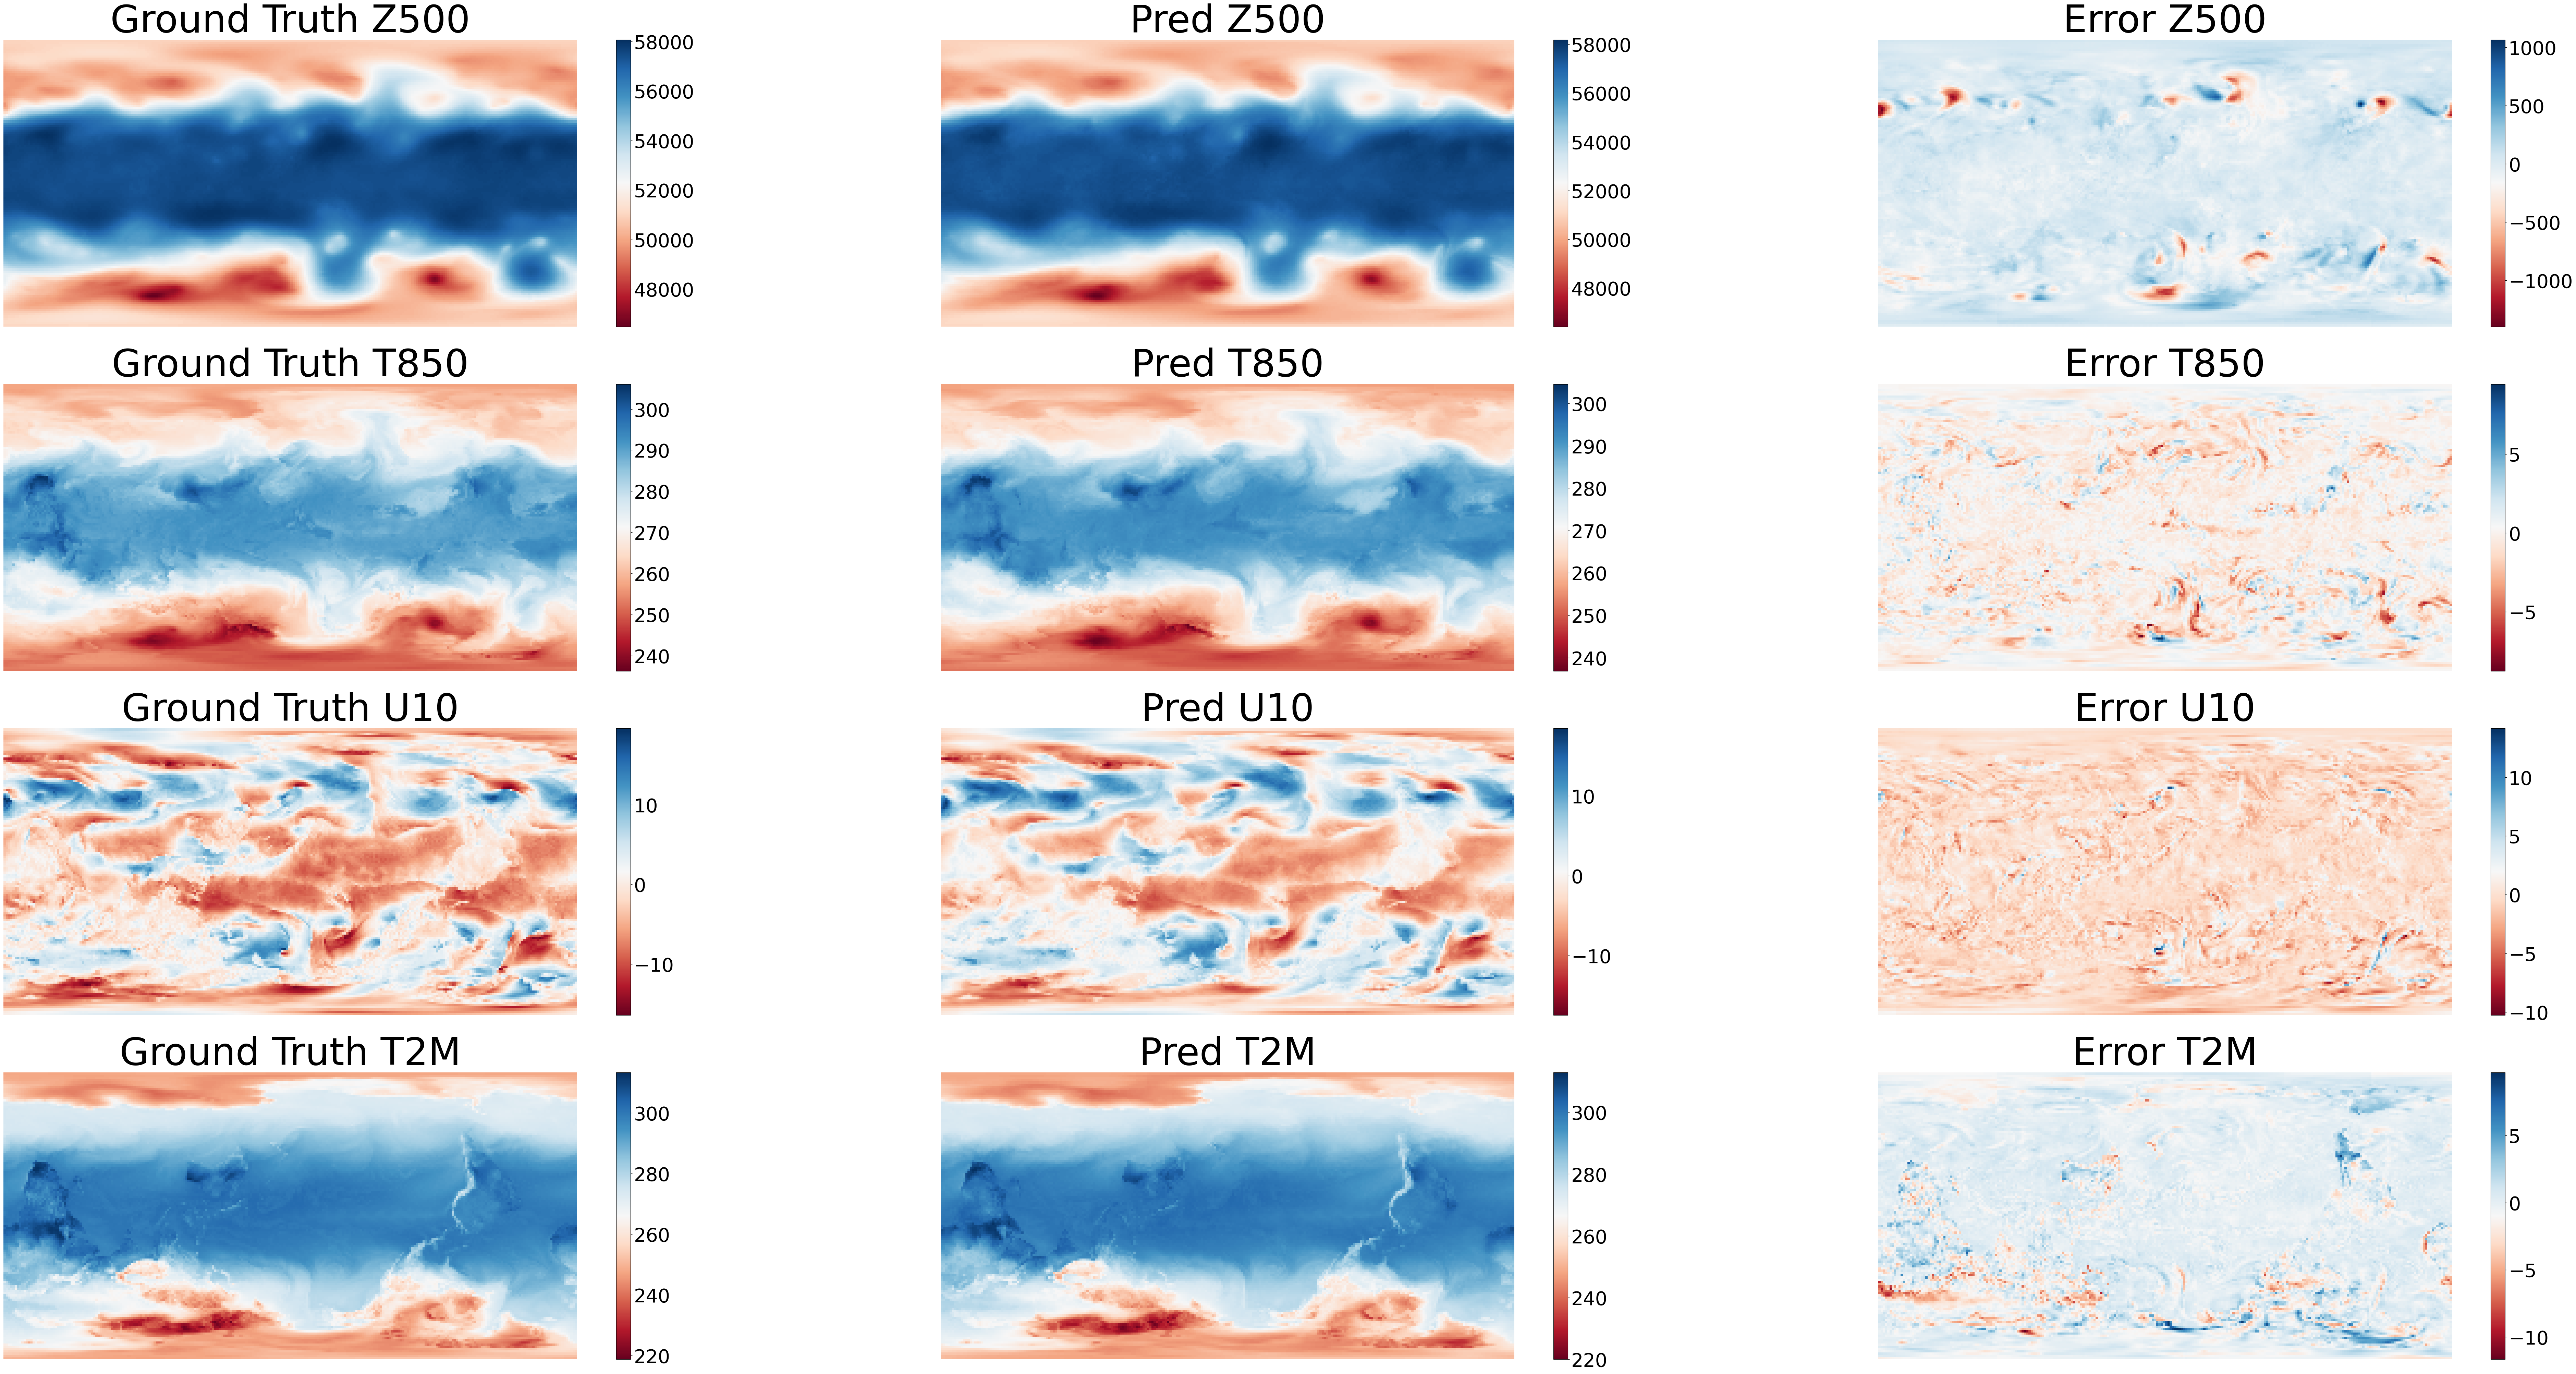

down


In [ ]:
plt_key_info_comparison(pred, labels, data_params.get('root_dir'))